**Netflix Reccomendations**

In [1]:
!pip install scikit-surprise

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from surprise import SVD, Reader, Dataset
from surprise.accuracy import rmse
from surprise.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357273 sha256=d3e352614cbf2155cdc8e13f582bd015dc14c396865e17b5504eed7818984ece
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [2]:
df = pd.read_csv('/content/netflix_titles-1 (1).csv')

In [4]:
df.head(10)

,ID,Movie Name,Rating,Genre
0,s1,Dick Johnson Is Dead,PG-13,Documentaries
1,s2,Blood & Water,TV-MA,"International TV Shows, TV Dramas, TV Mysteries"
2,s3,Ganglands,TV-MA,"Crime TV Shows, International TV Shows, TV Act..."
3,s4,Jailbirds New Orleans,TV-MA,"Docuseries, Reality TV"
4,s5,Kota Factory,TV-MA,"International TV Shows, Romantic TV Shows, TV ..."
5,s6,Midnight Mass,TV-MA,"TV Dramas, TV Horror, TV Mysteries"
6,s7,My Little Pony: A New Generation,PG,Children & Family Movies
7,s8,Sankofa,TV-MA,"Dramas, Independent Movies, International Movies"
8,s9,The Great British Baking Show,TV-14,"British TV Shows, Reality TV"
9,s10,The Starling,PG-13,"Comedies, Dramas"


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          8807 non-null   object
 1   Movie Name  8807 non-null   object
 2   Rating      8803 non-null   object
 3   Genre       8807 non-null   object
dtypes: object(4)
memory usage: 275.3+ KB


In [6]:
df.isna().sum()

,0
ID,0
Movie Name,0
Rating,4
Genre,0


In [7]:
print(f"Unique values in Rating column: {df['Rating'].unique()}")


rating_map = {
    'G': 1,
    'PG': 2,
    'PG-13': 3,
    'R': 4,
    'NC-17': 5,
    'TV-Y': 1,
    'TV-Y7': 2,
    'TV-G': 1,
    'TV-PG': 2,
    'TV-14': 3,
    'TV-MA': 4
}

# Filter data to include only rows with valid ratings
valid_ratings = set(rating_map.keys())
df = df[df['Rating'].isin(valid_ratings)]

# Map textual ratings to numerical values
df['Rating'] = df['Rating'].map(rating_map)

# Convert the Rating column to a numeric type
df['Rating'] = df['Rating'].astype(float)

print(df.head())

Unique values in Rating column: ['PG-13' 'TV-MA' 'PG' 'TV-14' 'TV-PG' 'TV-Y' 'TV-Y7' 'R' 'TV-G' 'G'
 'NC-17' '74 min' '84 min' '66 min' 'NR' nan 'TV-Y7-FV' 'UR']
   ID             Movie Name  Rating  \
0  s1   Dick Johnson Is Dead     3.0   
1  s2          Blood & Water     4.0   
2  s3              Ganglands     4.0   
3  s4  Jailbirds New Orleans     4.0   
4  s5           Kota Factory     4.0   

                                               Genre  
0                                      Documentaries  
1    International TV Shows, TV Dramas, TV Mysteries  
2  Crime TV Shows, International TV Shows, TV Act...  
3                             Docuseries, Reality TV  
4  International TV Shows, Romantic TV Shows, TV ...  


<ipython-input-7-6735a4836527>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Rating'] = df['Rating'].map(rating_map)
<ipython-input-7-6735a4836527>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Rating'] = df['Rating'].astype(float)


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8711 entries, 0 to 8806
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          8711 non-null   object 
 1   Movie Name  8711 non-null   object 
 2   Rating      8711 non-null   float64
 3   Genre       8711 non-null   object 
dtypes: float64(1), object(3)
memory usage: 340.3+ KB


**Objective - 1** Findout the list of most popular and liked genre

In [9]:
popular_genres = df['Genre'].value_counts()
avg_rating_genre = df.groupby('Genre')['Rating'].mean().sort_values(ascending=False)


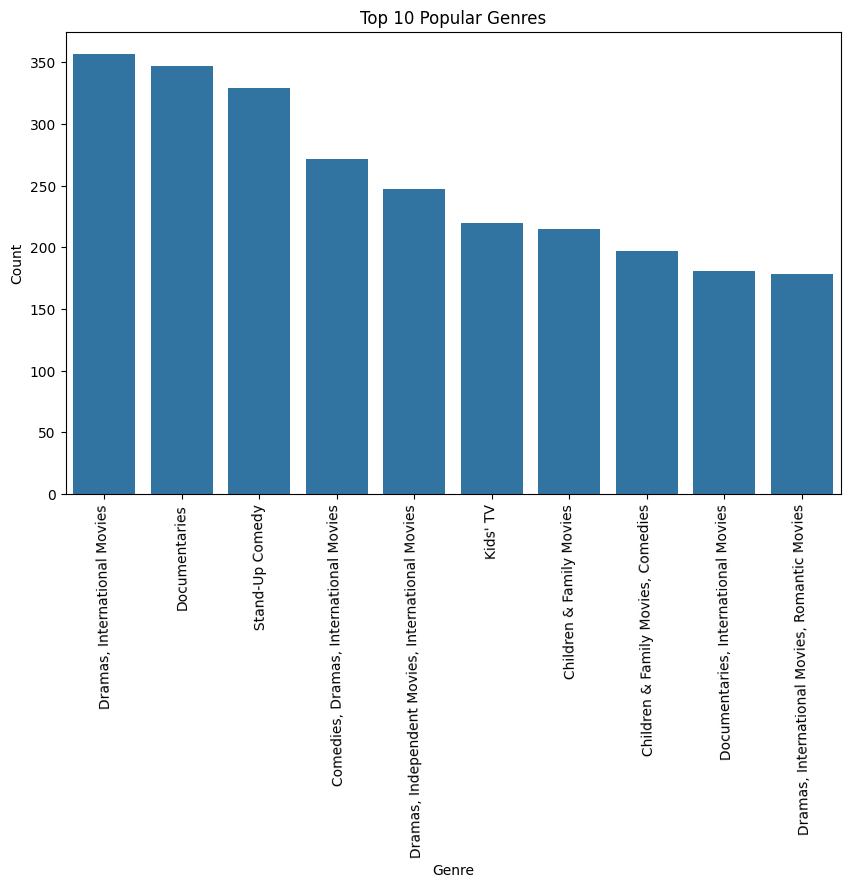

In [19]:
plt.figure(figsize=(10, 6))
sns.barplot(x=popular_genres.index[:10], y=popular_genres.values[:10])
plt.title('Top 10 Popular Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=91)
plt.show()

**Objective - 2** To Create Model that finds the best suited Movie for one
user in every genre

In [20]:

print(f"Data shape after preprocessing: {df.shape}")

print("Number of missing values in each column:\n", df.isnull().sum())

print("Unique values in Rating column after preprocessing:\n", df['Rating'].unique())


if df.empty:
    print("The dataset is empty. Adjust preprocessing or filtering logic.")



Data shape after preprocessing: (8711, 4)
Number of missing values in each column:
 ID            0
Movie Name    0
Rating        0
Genre         0
dtype: int64
Unique values in Rating column after preprocessing:
 [3. 4. 2. 1. 5.]


In [22]:
reader = Reader(rating_scale=(df['Rating'].min(), df['Rating'].max()))
surprise_data = Dataset.load_from_df(df[['ID', 'Movie Name', 'Rating']], reader)

# Train-test split using Surprise
trainset, testset = train_test_split(surprise_data, test_size=0.2)

#  Train the SVD model
model = SVD()
model.fit(trainset)

# Evaluate the model on the test set
predictions = model.test(testset)
rmse_value = rmse(predictions)

print(f"RMSE of the model: {rmse_value}")

RMSE: 0.9284
RMSE of the model: 0.9283778991856283


In [23]:
# Recommending movies for a specific user
def recommend_movies(user_id, genre=None, top_n=5):
    user_data = df[df['ID'] == user_id]
    if genre:
        user_data = user_data[user_data['Genre'] == genre]
    recommendations = user_data.sort_values('Rating', ascending=False).head(top_n)
    return recommendations

**Objective - 3** To Find what Genre Movies have received the best and
worst ratings based on User Rating.

In [24]:
best_genres = avg_rating_genre.head()
worst_genres = avg_rating_genre.tail()
print("Best Genres:", best_genres)
print()
print("Worst Genres:", worst_genres)

Best Genres: Genre
Classic Movies, Independent Movies, Thrillers           4.0
Independent Movies, Sci-Fi & Fantasy, Thrillers         4.0
Crime TV Shows, TV Dramas, TV Horror                    4.0
Horror Movies, International Movies, Romantic Movies    4.0
Anime Series, Crime TV Shows, TV Horror                 4.0
Name: Rating, dtype: float64

Worst Genres: Genre
Documentaries, Faith & Spirituality, Music & Musicals    1.0
British TV Shows, Classic & Cult TV, Kids' TV            1.0
Action & Adventure, Classic Movies, Sci-Fi & Fantasy     1.0
Music & Musicals, Romantic Movies                        1.0
Kids' TV, Reality TV, TV Dramas                          1.0
Name: Rating, dtype: float64
